### Initialization

In [2]:
# Libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchmetrics.classification import MulticlassAccuracy
import matplotlib.pyplot as plt
from pathlib import Path
from timeit import default_timer as timer
from tqdm.auto import tqdm
from helper_functions import train_step, test_step

# Path to models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"PyTorch: {torch.__version__}")

PyTorch: 2.1.1+cu121


c:\Users\drobi\OneDrive\Documents\GitHub\LearningPortfolio\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup Data

In [3]:
# Training data
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# Testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

### Prepare DataLoader

In [4]:
BATCH_SIZE = 100

# Turn datasets into iterables over batches
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

### Visualize first batch

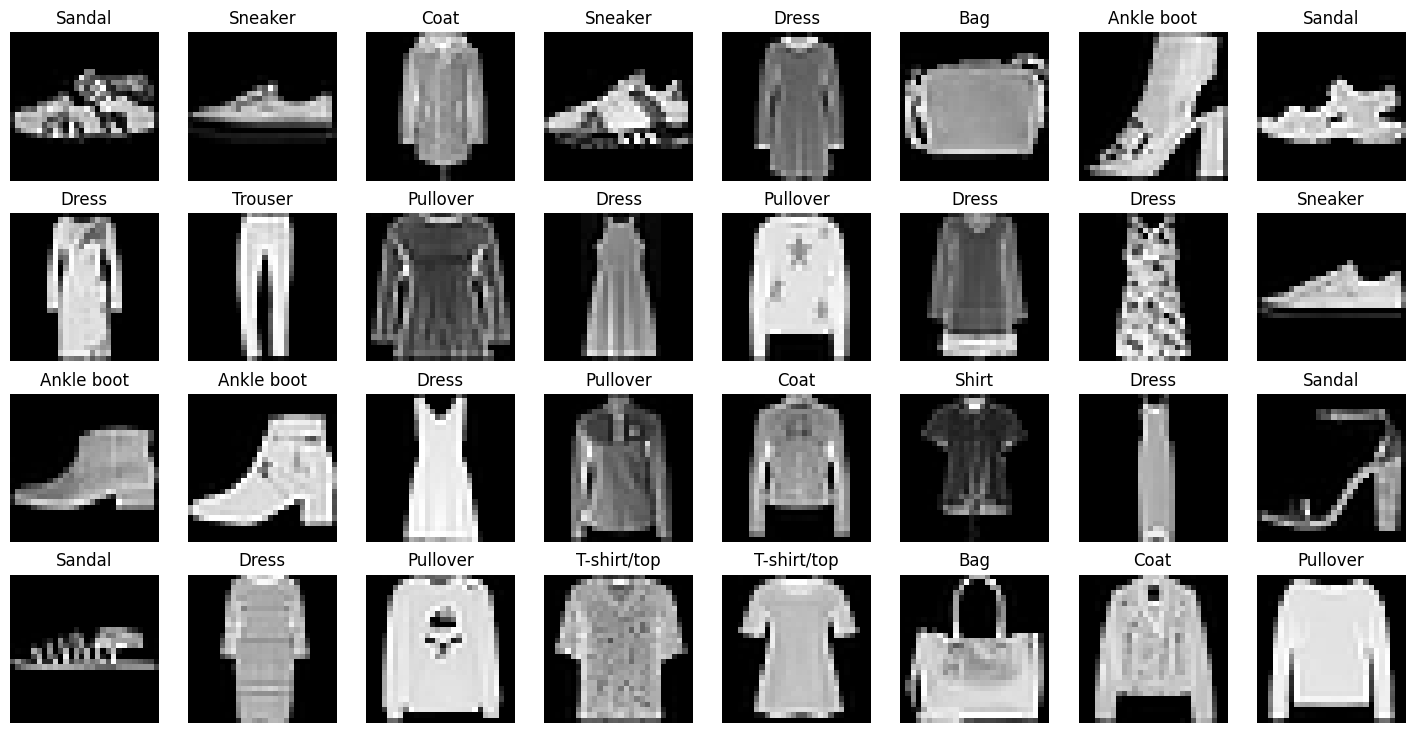

In [5]:
torch.manual_seed(42)
fig = plt.figure(figsize=(18, 9))
rows, cols = 4, 8

# Get random batch
batch_features, batch_labels = next(iter(train_dataloader))

for i in range(0, 32):
    img, label = batch_features[i], batch_labels[i]
    
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(train_data.classes[label])
    plt.axis(False)

# Build Simple Model

In [6]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            # nn.ReLU()
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [7]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=784, 
    hidden_units=10, 
    output_shape=len(train_data.classes)
).to(device)

## Train Model

### Setup loss function, optimizer, and evaluation metrics

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
accuracy_fn = MulticlassAccuracy(num_classes=len(train_data.classes)).to(device)

### Training and testing loops

In [9]:
torch.manual_seed(42)
start = timer()
epochs = 1

for epoch in tqdm(range(epochs)):
    # Training
    train_step(
        model=model_0, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        device=device
    )
    
    # Testing
    result = test_step(
        model=model_0, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn, 
        accuracy_fn=accuracy_fn, 
        device=device
    )

end = timer()
train_time = end - start
print(f"Final Loss: {result['loss']:.5f} | Final Accuracy: {result['accuracy']:.2f}%")
print(f"Training Time: {(str(int(train_time / 60)) + ' min ') if train_time >= 60 else ''}{(train_time % 60):.3f} sec")

100%|██████████| 1/1 [00:10<00:00, 10.32s/it]

Final Loss: 0.53076 | Final Accuracy: 81.48%
Training Time: 10.325 sec


# Rebuild Model as Convolutional Neural Network

In [10]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden1: int, hidden2: int, output_shape: int, imgsize: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden1, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden1, out_channels=hidden2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=imgsize * 4, out_features=600),
            nn.Dropout(0.25),
            nn.Linear(in_features=600, out_features=120),
            nn.Linear(in_features=120, out_features=output_shape)
        )
        self.layer_stack = nn.Sequential(
            self.block_1,
            self.block_2,
            self.classifier
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)

In [11]:
torch.manual_seed(42)

model_1 = FashionMNISTModelV1(1, 32, 64, len(train_data.classes), 28 * 28).to(device)

### Training and testing loops

In [12]:
torch.manual_seed(42)
start = timer()
epochs = 100
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.001)
# lambdafn = lambda epoch: 0.8
# scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambdafn)
accuracy_fn = MulticlassAccuracy(num_classes=len(train_data.classes)).to(device)

for epoch in tqdm(range(epochs)):
    ### Training ###
    model_1.train()
    avg_train_loss, avg_train_acc = 0, 0
    
    # Loop through training batches
    for X, y in train_dataloader:
        # Transfer to GPU
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model_1(X)
        
        # Calculate the loss
        loss = loss_fn(y_pred, y)
        acc = accuracy_fn(y_pred.argmax(dim=1), y) * 100
        avg_train_loss += loss.detach().cpu().numpy()
        avg_train_acc += acc.detach().cpu().numpy()
        
        # Perform backpropagation on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_train_loss /= len(train_dataloader)
    avg_train_acc /= len(train_dataloader)
    train_loss_values.append(avg_train_loss)
    train_acc_values.append(avg_train_acc)
    
    ### Testing ###
    model_1.eval()
    avg_test_loss, avg_test_acc = 0, 0
    i = 0
    
    with torch.inference_mode():
        # Loop through testing batches
        for X, y in test_dataloader:
            # Transfer to GPU
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            test_pred = model_1(X)
            
            # Calculate loss and accuracy
            test_loss = loss_fn(test_pred, y)
            test_acc = accuracy_fn(test_pred.argmax(dim=1), y) * 100
            
            avg_test_loss += test_loss.detach().cpu().numpy()
            avg_test_acc += test_acc.detach().cpu().numpy()

        avg_test_loss /= len(test_dataloader)
        avg_test_acc /= len(test_dataloader)
        test_loss_values.append(avg_test_loss)
        test_acc_values.append(avg_test_acc)
        print(f"Loss: {avg_test_loss:.5f} | Accuracy: {avg_test_acc:.2f}%")
        
    # scheduler.step()
    
end = timer()
train_time = end - start
print(f"Final Loss: {avg_test_loss:.5f} | Final Accuracy: {avg_test_acc:.2f}%")
print(f"Training Time: {(str(int(train_time / 60)) + ' min ') if train_time >= 60 else ''}{(train_time % 60):.3f} sec")

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:14<23:16, 14.10s/it]

Loss: 0.34252 | Accuracy: 87.61%


  2%|▏         | 2/100 [00:25<20:26, 12.51s/it]

Loss: 0.30177 | Accuracy: 89.12%


  3%|▎         | 3/100 [00:36<19:23, 11.99s/it]

Loss: 0.28946 | Accuracy: 89.82%


  4%|▍         | 4/100 [00:48<18:49, 11.76s/it]

Loss: 0.27208 | Accuracy: 90.10%


  5%|▌         | 5/100 [00:59<18:24, 11.63s/it]

Loss: 0.27379 | Accuracy: 90.55%


  6%|▌         | 6/100 [01:11<18:05, 11.55s/it]

Loss: 0.25865 | Accuracy: 90.92%


  7%|▋         | 7/100 [01:22<17:49, 11.51s/it]

Loss: 0.25045 | Accuracy: 91.21%


  8%|▊         | 8/100 [01:33<17:35, 11.47s/it]

Loss: 0.25811 | Accuracy: 91.12%


  9%|▉         | 9/100 [01:45<17:21, 11.44s/it]

Loss: 0.28564 | Accuracy: 90.68%


 10%|█         | 10/100 [01:56<17:09, 11.44s/it]

Loss: 0.29041 | Accuracy: 90.09%


 11%|█         | 11/100 [02:08<16:57, 11.43s/it]

Loss: 0.27447 | Accuracy: 90.86%


 12%|█▏        | 12/100 [02:19<16:44, 11.42s/it]

Loss: 0.27450 | Accuracy: 90.61%


 13%|█▎        | 13/100 [02:30<16:33, 11.42s/it]

Loss: 0.27305 | Accuracy: 91.14%


 14%|█▍        | 14/100 [02:42<16:21, 11.41s/it]

Loss: 0.27277 | Accuracy: 91.11%


 15%|█▌        | 15/100 [02:53<16:09, 11.40s/it]

Loss: 0.32254 | Accuracy: 89.74%


 16%|█▌        | 16/100 [03:05<15:57, 11.39s/it]

Loss: 0.29980 | Accuracy: 90.58%


 17%|█▋        | 17/100 [03:16<15:46, 11.41s/it]

Loss: 0.29716 | Accuracy: 90.68%


 18%|█▊        | 18/100 [03:27<15:35, 11.41s/it]

Loss: 0.30913 | Accuracy: 90.46%


 19%|█▉        | 19/100 [03:39<15:23, 11.40s/it]

Loss: 0.31972 | Accuracy: 90.68%


 20%|██        | 20/100 [03:50<15:14, 11.44s/it]

Loss: 0.37662 | Accuracy: 89.42%


 21%|██        | 21/100 [04:02<15:03, 11.44s/it]

Loss: 0.32407 | Accuracy: 90.67%


 22%|██▏       | 22/100 [04:13<14:50, 11.42s/it]

Loss: 0.33804 | Accuracy: 90.36%


 23%|██▎       | 23/100 [04:25<14:38, 11.42s/it]

Loss: 0.31623 | Accuracy: 90.88%


 24%|██▍       | 24/100 [04:36<14:27, 11.41s/it]

Loss: 0.33150 | Accuracy: 90.75%


 25%|██▌       | 25/100 [04:47<14:15, 11.41s/it]

Loss: 0.34504 | Accuracy: 90.57%


 26%|██▌       | 26/100 [04:59<14:05, 11.42s/it]

Loss: 0.37319 | Accuracy: 89.89%


 27%|██▋       | 27/100 [05:10<13:53, 11.41s/it]

Loss: 0.38340 | Accuracy: 90.25%


 28%|██▊       | 28/100 [05:22<13:41, 11.41s/it]

Loss: 0.39409 | Accuracy: 89.82%


 29%|██▉       | 29/100 [05:33<13:29, 11.40s/it]

Loss: 0.40757 | Accuracy: 89.82%


 30%|███       | 30/100 [05:44<13:17, 11.40s/it]

Loss: 0.39243 | Accuracy: 90.39%


 31%|███       | 31/100 [05:56<13:06, 11.39s/it]

Loss: 0.42339 | Accuracy: 90.02%


 32%|███▏      | 32/100 [06:07<12:54, 11.39s/it]

Loss: 0.42368 | Accuracy: 90.15%


 33%|███▎      | 33/100 [06:18<12:42, 11.38s/it]

Loss: 0.42063 | Accuracy: 90.35%


 34%|███▍      | 34/100 [06:30<12:31, 11.39s/it]

Loss: 0.46133 | Accuracy: 89.66%


 35%|███▌      | 35/100 [06:41<12:21, 11.41s/it]

Loss: 0.46638 | Accuracy: 89.90%


 36%|███▌      | 36/100 [06:53<12:09, 11.39s/it]

Loss: 0.48044 | Accuracy: 89.91%


 37%|███▋      | 37/100 [07:04<11:57, 11.39s/it]

Loss: 0.45276 | Accuracy: 90.31%


 38%|███▊      | 38/100 [07:15<11:45, 11.38s/it]

Loss: 0.47438 | Accuracy: 90.01%


 39%|███▉      | 39/100 [07:27<11:37, 11.43s/it]

Loss: 0.50857 | Accuracy: 89.53%


 40%|████      | 40/100 [07:38<11:25, 11.42s/it]

Loss: 0.47080 | Accuracy: 90.47%


 41%|████      | 41/100 [07:50<11:13, 11.41s/it]

Loss: 0.55433 | Accuracy: 89.45%


 42%|████▏     | 42/100 [08:01<11:01, 11.41s/it]

Loss: 0.49059 | Accuracy: 90.26%


 43%|████▎     | 43/100 [08:13<10:50, 11.41s/it]

Loss: 0.50070 | Accuracy: 90.28%


 44%|████▍     | 44/100 [08:24<10:39, 11.41s/it]

Loss: 0.54341 | Accuracy: 89.55%


 45%|████▌     | 45/100 [08:35<10:27, 11.42s/it]

Loss: 0.54249 | Accuracy: 90.06%


 46%|████▌     | 46/100 [08:47<10:15, 11.40s/it]

Loss: 0.52307 | Accuracy: 90.28%


 47%|████▋     | 47/100 [08:58<10:04, 11.40s/it]

Loss: 0.55702 | Accuracy: 90.12%


 48%|████▊     | 48/100 [09:10<09:53, 11.42s/it]

Loss: 0.58875 | Accuracy: 89.94%


 49%|████▉     | 49/100 [09:21<09:42, 11.43s/it]

Loss: 0.54246 | Accuracy: 90.04%


 50%|█████     | 50/100 [09:33<09:30, 11.41s/it]

Loss: 0.57370 | Accuracy: 90.14%


 51%|█████     | 51/100 [09:44<09:19, 11.41s/it]

Loss: 0.55959 | Accuracy: 90.20%


 52%|█████▏    | 52/100 [09:55<09:07, 11.40s/it]

Loss: 0.59145 | Accuracy: 90.19%


 53%|█████▎    | 53/100 [10:07<08:55, 11.40s/it]

Loss: 0.58404 | Accuracy: 89.68%


 54%|█████▍    | 54/100 [10:18<08:43, 11.39s/it]

Loss: 0.59189 | Accuracy: 90.11%


 55%|█████▌    | 55/100 [10:29<08:32, 11.39s/it]

Loss: 0.61510 | Accuracy: 90.16%


 56%|█████▌    | 56/100 [10:41<08:21, 11.40s/it]

Loss: 0.63886 | Accuracy: 89.74%


 57%|█████▋    | 57/100 [10:52<08:10, 11.40s/it]

Loss: 0.61482 | Accuracy: 90.08%


 58%|█████▊    | 58/100 [11:04<07:58, 11.40s/it]

Loss: 0.62608 | Accuracy: 90.18%


 59%|█████▉    | 59/100 [11:15<07:47, 11.41s/it]

Loss: 0.64323 | Accuracy: 89.74%


 60%|██████    | 60/100 [11:26<07:35, 11.40s/it]

Loss: 0.65389 | Accuracy: 90.00%


 61%|██████    | 61/100 [11:38<07:24, 11.40s/it]

Loss: 0.68799 | Accuracy: 89.61%


 62%|██████▏   | 62/100 [11:49<07:13, 11.40s/it]

Loss: 0.66887 | Accuracy: 89.79%


 63%|██████▎   | 63/100 [12:01<07:01, 11.39s/it]

Loss: 0.71577 | Accuracy: 89.49%


 64%|██████▍   | 64/100 [12:12<06:49, 11.39s/it]

Loss: 0.67982 | Accuracy: 90.26%


 65%|██████▌   | 65/100 [12:23<06:38, 11.39s/it]

Loss: 0.69557 | Accuracy: 90.03%


 66%|██████▌   | 66/100 [12:35<06:27, 11.41s/it]

Loss: 0.71479 | Accuracy: 89.68%


 67%|██████▋   | 67/100 [12:46<06:16, 11.40s/it]

Loss: 0.71092 | Accuracy: 90.22%


 68%|██████▊   | 68/100 [12:58<06:04, 11.40s/it]

Loss: 0.69700 | Accuracy: 89.97%


 69%|██████▉   | 69/100 [13:09<05:53, 11.40s/it]

Loss: 0.71024 | Accuracy: 89.92%


 70%|███████   | 70/100 [13:20<05:41, 11.40s/it]

Loss: 0.69498 | Accuracy: 90.04%


 71%|███████   | 71/100 [13:32<05:30, 11.39s/it]

Loss: 0.69389 | Accuracy: 90.06%


 72%|███████▏  | 72/100 [13:43<05:18, 11.39s/it]

Loss: 0.71857 | Accuracy: 89.80%


 73%|███████▎  | 73/100 [13:55<05:07, 11.40s/it]

Loss: 0.70492 | Accuracy: 89.96%


 74%|███████▍  | 74/100 [14:06<04:56, 11.39s/it]

Loss: 0.73545 | Accuracy: 90.10%


 75%|███████▌  | 75/100 [14:17<04:44, 11.40s/it]

Loss: 0.72080 | Accuracy: 90.15%


 76%|███████▌  | 76/100 [14:29<04:33, 11.41s/it]

Loss: 0.77815 | Accuracy: 89.77%


 77%|███████▋  | 77/100 [14:40<04:22, 11.41s/it]

Loss: 0.80632 | Accuracy: 89.38%


 78%|███████▊  | 78/100 [14:52<04:10, 11.41s/it]

Loss: 0.76289 | Accuracy: 89.50%


 79%|███████▉  | 79/100 [15:03<03:59, 11.40s/it]

Loss: 0.76538 | Accuracy: 89.94%


 80%|████████  | 80/100 [15:14<03:47, 11.39s/it]

Loss: 0.74872 | Accuracy: 89.72%


 81%|████████  | 81/100 [15:26<03:36, 11.39s/it]

Loss: 0.74691 | Accuracy: 90.23%


 82%|████████▏ | 82/100 [15:37<03:25, 11.39s/it]

Loss: 0.78193 | Accuracy: 89.69%


 83%|████████▎ | 83/100 [15:49<03:13, 11.39s/it]

Loss: 0.75870 | Accuracy: 89.83%


 84%|████████▍ | 84/100 [16:00<03:02, 11.40s/it]

Loss: 0.75722 | Accuracy: 89.93%


 85%|████████▌ | 85/100 [16:11<02:51, 11.40s/it]

Loss: 0.77710 | Accuracy: 89.76%


 86%|████████▌ | 86/100 [16:23<02:39, 11.39s/it]

Loss: 0.85030 | Accuracy: 89.36%


 87%|████████▋ | 87/100 [16:34<02:27, 11.38s/it]

Loss: 0.80604 | Accuracy: 89.76%


 88%|████████▊ | 88/100 [16:46<02:16, 11.39s/it]

Loss: 0.77215 | Accuracy: 89.95%


 89%|████████▉ | 89/100 [16:57<02:05, 11.38s/it]

Loss: 0.76315 | Accuracy: 90.13%


 90%|█████████ | 90/100 [17:08<01:53, 11.37s/it]

Loss: 0.83006 | Accuracy: 89.63%


 91%|█████████ | 91/100 [17:20<01:42, 11.37s/it]

Loss: 0.78406 | Accuracy: 89.83%


 92%|█████████▏| 92/100 [17:31<01:30, 11.37s/it]

Loss: 0.77858 | Accuracy: 90.00%


 93%|█████████▎| 93/100 [17:42<01:19, 11.38s/it]

Loss: 0.81037 | Accuracy: 89.84%


 94%|█████████▍| 94/100 [17:54<01:08, 11.39s/it]

Loss: 0.83243 | Accuracy: 89.69%


 95%|█████████▌| 95/100 [18:05<00:56, 11.40s/it]

Loss: 0.82731 | Accuracy: 89.28%


 96%|█████████▌| 96/100 [18:17<00:45, 11.40s/it]

Loss: 0.84554 | Accuracy: 89.84%


 97%|█████████▋| 97/100 [18:28<00:34, 11.48s/it]

Loss: 0.86316 | Accuracy: 89.41%


 98%|█████████▊| 98/100 [18:40<00:22, 11.49s/it]

Loss: 0.82726 | Accuracy: 89.80%


 99%|█████████▉| 99/100 [18:51<00:11, 11.44s/it]

Loss: 0.86323 | Accuracy: 89.69%


100%|██████████| 100/100 [19:03<00:00, 11.43s/it]

Loss: 0.99801 | Accuracy: 88.39%
Final Loss: 0.99801 | Final Accuracy: 88.39%
Training Time: 19 min 3.009 sec


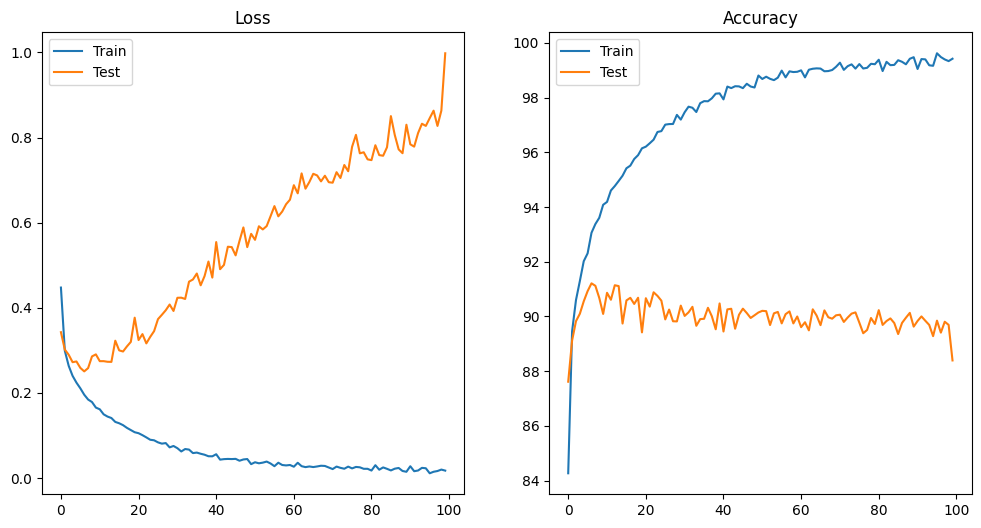

In [13]:
# plt.plot(range(epochs), loss_values, label="Loss")
# plt.title("Loss curves")
# plt.ylabel("Loss")
# plt.xlabel("Epochs")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(range(epochs), train_loss_values, label="Train")
plt.plot(range(epochs), test_loss_values, label="Test")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(range(epochs), train_acc_values, label="Train")
plt.plot(range(epochs), test_acc_values, label="Test")
plt.legend();
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.title("Train")
# plot_decision_boundary(model_0, X_train, y_train)
# plt.subplot(1, 2, 2)
# plt.title("Test")
# plot_decision_boundary(model_0, X_test, y_test)

In [14]:
MODEL_NAME = "fashionMNIST_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\fashionMNIST_model.pth
